Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

100%|██████████| 18165135/18165135 [00:09<00:00, 1863112.05it/s]


Extracting ./KMNIST/KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 244297.11it/s]


Extracting ./KMNIST/KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/KMNIST/raw



100%|██████████| 3041136/3041136 [00:02<00:00, 1080722.14it/s]


Extracting ./KMNIST/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 17057058.36it/s]


Extracting ./KMNIST/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/KMNIST/raw



NameError: name 'clear_output' is not defined

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** С увеличением размера батча обычно наблюдается более быстрое и менее точное обучение,
я думаю это потому что при одинаковых параметрах большой батч будет требовать больше итераций и вычислительной памяти для обучения.

Посмотрим на какую-нибудь картинку:

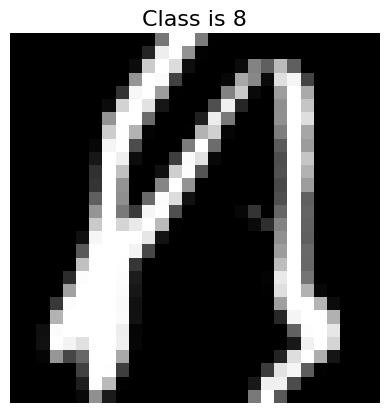

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





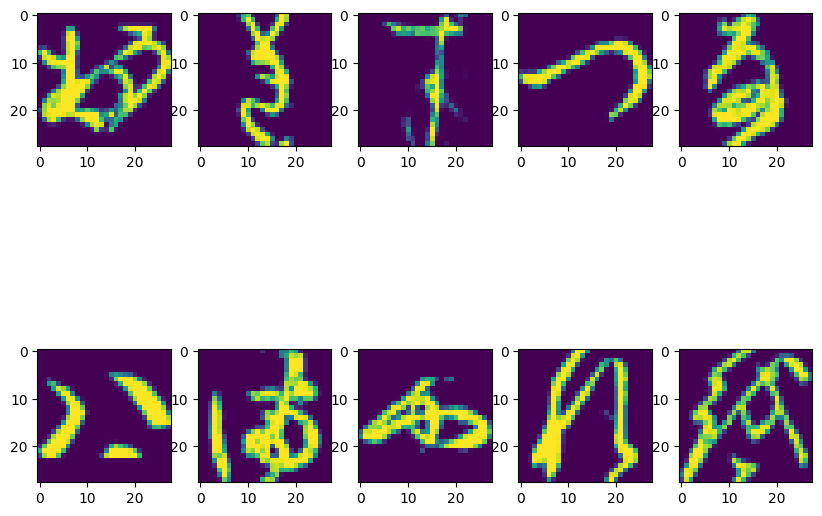

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 8))


for i in range(10):
    images = [n for n, cls in enumerate(trainset.targets) if cls == i]
    image, cls = trainset[images[0]]
    axs[i // 5, i % 5].imshow(image.squeeze())

plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.ELU()


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**
весов:200704, 32768, 1280 \\
смещение: 394

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        preds = fc_net(images)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

0.731

In [ ]:
get_accuracy(fc_net, testloader)

0.8656

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = trainset.data.float().mean() / 255
std = trainset.data.float().std() / 255
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        preds = fc_net(images)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


In [ ]:
get_accuracy(fc_net, testloader)

0.8968

Как изменилась `accuracy` после нормализации?

In [ ]:
#повысилось, точнее предсказания после нормализации

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:

activation_functions = [nn.Sigmoid(), nn.Tanh(), nn.GELU(approximate='none')]

accuracies = []
for act_fun in activation_functions:
      n_epochs = 10
      #loss_history = []
      fc_net = FCNet()
      fc_net.activation = act_fun
      loss_function = nn.CrossEntropyLoss()
      lr = 0.001
      optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
      for epoch in range(n_epochs):
              epoch_loss = 0
              for images, labels in trainloader:
                  optimizer.zero_grad()
                  preds = fc_net(images)
                  loss = loss_function(preds, labels)
                  loss.backward()
                  optimizer.step()
                  epoch_loss += loss.item()
              #loss_history.append(epoch_loss / len(trainloader))


      accuracy = get_accuracy(fc_net, testloader)
      accuracies.append((act_fun.__class__.__name__, accuracy))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
for act_fun, accuracy in accuracies:
  print(act_fun, ":", accuracy)

Sigmoid : 0.8532
Tanh : 0.9004
GELU : 0.9019


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [ ]:
#GELU чуть лучше Tanh

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]

accuracies2 = []
for optimizer in optimizers:
    n_epochs = 10
    #loss_history = []
    fc_net = FCNet()
    fc_net.activation = nn.GELU()
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = optimizer(fc_net.parameters(), lr=lr)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            preds = fc_net(images)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        #loss_history.append(epoch_loss / len(trainloader))

    accuracy = get_accuracy(fc_net, testloader)
    accuracies2.append((optimizer.__class__.__name__, accuracy))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
for optimizer, accuracy in accuracies2:
    print(optimizer,':', accuracy)

Adam : 0.9062
RMSprop : 0.8952
Adagrad : 0.8159


In [ ]:
#у Adam наибольшая точность, поэтому дальше его использую

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        return torch.max(torch.tensor(0.0), x)

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
fc_net_relu = FCNet()
loss_function = nn.CrossEntropyLoss()
fc_net_relu.activation = CustomReLU()
lr = 0.001
optimizer_relu = torch.optim.Adam(fc_net_relu.parameters(), lr=3e-4)

n_epochs = 10

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer_relu.zero_grad()
        outputs = fc_net_relu(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer_relu.step()
        epoch_loss += loss.item()

    #loss_history_custom_relu.append(epoch_loss / len(trainloader))

    accuracy_relu = get_accuracy(fc_net_relu, testloader)




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
print("Accuracy with ReLU actiovation function:", accuracy_relu)

Accuracy with ReLU actiovation function: 0.8991


### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

'Oxford ', style — aivazovsky



https://drive.google.com/file/d/15hZHthdtKsL9_5DzK9WdSxLwbHGhaqvO/view?usp=share_link

---



'University graduation' - Советсвкий мультфильм

https://drive.google.com/file/d/1X8osA2Gli0nwNXdPwK4DmSr9LYRRdV1E/view?usp=share_link

'Traveling' - живопись

https://drive.google.com/file/d/1DcJdTTkAegct-YQlzvn0sykAXOyWZcx4/view?usp=share_link